# TN Ex 02: Predictive Coding & the Hierarchical Gaussian Filter
Spring Semester 2024

**Exercise submission deadline** (via Moodle): Tuesday 6pm, April 9, 2024.

Exercise discussion: Friday 2pm, April 12, 2024.

Please enter your exercise group (number + names of all group members): 


- Exercise group <mark>5<mark>

- members: <mark>Jason Li, Jérôme Hadorn<mark>


## References

**Julia**
- The [Julia Programming Language](https://julialang.org/)
- A useful reference to help you set up your Julia environment and run an interactive notebook: https://julia.quantecon.org/getting_started_julia/getting_started.html
- Julia [Cheat Sheet](https://cheatsheet.juliadocs.org/)

**Predictive Coding**
- Bogacz et al. (2017): https://doi.org/10.1016/j.jmp.2015.11.003

**Hierarchical Gaussian Filtering**
- Mathys et al. (2011) https://doi.org/10.3389/fnhum.2011.00039 & Mathys et al. (2014) https://doi.org/10.3389/fnhum.2014.00825
- The 'generalized HGF' (Weber et al. 2023): https://doi.org/10.48550/arXiv.2305.10937
- [HGF Julia package](https://github.com/ilabcode/HierarchicalGaussianFiltering.jl/tree/main) incl [docs](https://ilabcode.github.io/HierarchicalGaussianFiltering.jl/dev/)
- [Action Models Julia package](https://github.com/ilabcode/ActionModels.jl)


## Setup

The `versioninfo()` function should print your Julia version and some other info about the system:

In [5]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (x86_64-apple-darwin22.4.0)
  CPU: 8 × Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, skylake)
Threads: 1 default, 0 interactive, 1 GC (on 8 virtual cores)
Environment:
  JULIA_NUM_THREADS = 


Now we need to activate our project environment and load a few julia packages which are specified in the Project.toml file.

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/JH/2_ACADEMIA/NSC_MSC/2024FS_Translational_Neuromodelling/translational_neuromodelling2/ex02`


In [3]:
activate Project.toml

UndefVarError: UndefVarError: `activate` not defined

In [9]:
] activate .

Base.Meta.ParseError: ParseError:
# Error @ /Users/jasonli/Documents/NSC/classes/spring2024/neuromodeling/exs/ex02/ex02_pc_hgf.ipynb:1:1
] activate .
╙ ── unexpected `]`

In [4]:
Pkg.add("ActionModels")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Distributions")
Pkg.add("HierarchicalGaussianFiltering")
Pkg.add("IJulia")
Pkg.add("LaTeXStrings")
Pkg.add("LogExpFunctions")
Pkg.add("Optim")
Pkg.add("Plots")
Pkg.add("Random")
Pkg.add("StatsPlots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed LRUCache ────────────────────── v1.6.1
   Installed AbstractMCMC ────────────────── v5.2.0
   Installed FFTW ────────────────────────── v1.8.0
   Installed AdvancedPS ──────────────────── v0.5.4
   Installed StatisticalTraits ───────────── v3.2.0
   Installed Accessors ───────────────────── v0.1.36
   Installed OffsetArrays ────────────────── v1.13.0
   Installed AxisArrays ──────────────────── v0.4.7
   Installed NNlib ───────────────────────── v0.9.12
   Installed ConcurrentUtilities ─────────── v2.4.1
   Installed NaturalSort ─────────────────── v1.0.0
   Installed InlineStrings ───────────────── v1.4.0
   Installed Optimisers ──────────────────── v0.3.2
   Installed StaticArrays ────────────────── v1.9.3
   Installed Turing ──────────────────────── v0.30.7
   Installed CEnum ───────────────────────── v0.5.0
   Installed InitialValues ───────────────── v0.3.1
   Installed Neares

In [20]:
using Plots

In [67]:
# load packages
using Random
using Plots
using LaTeXStrings
using Optim

using Printf
using Statistics
using LinearAlgebra

# HGF
using HierarchicalGaussianFiltering
using ActionModels
using StatsPlots
using Distributions
using CSV
using DataFrames
using LogExpFunctions

For reproducibility purposes, we fix the seed of the random number generator.

In [68]:
# fix rng seed
rng = MersenneTwister(1234)

MersenneTwister(1234)

&nbsp;
___
___
&nbsp;

## Exercise 2.1: Speed of convergence in Predictive Coding

In this exercise, we will have a closer look on the convergence behaviour of predictive coding algorithms. We use the same model as [Bogacz (2017)](https://doi.org/10.1016/j.jmp.2015.11.003), so we have 
\begin{align}
p(x) &=  \frac{1}{\sqrt{2\pi\Sigma_{pr}}} \exp^{-\frac{(x-\mu_{pr})^2}{2\Sigma_{pr}}} \\
p(y|x) &= \frac{1}{\sqrt{2\pi\Sigma_{gen}}} \exp^{-\frac{(y - g(x))^2}{2\Sigma_{gen}}}
\end{align}  
for prior $p(x)$ and likelihood $p(y|x)$, where $g(x)=x^2$.
To enable concrete calculations, we set $\Sigma_{pr} = 1$, $\Sigma_{gen} = 1$, $\mu_{pr} = 3$. In addition, we assume that we observe $y = 2$.

We want to approximate our posterior $p(x|y)$ by a delta-distribution $q_\phi(x) = \delta(x - \phi)$. We could do that for every $\phi$, but we want to find the value $\phi_0$, s.t. the delta-distribution is nonzero at the maximum of the posterior. One can show (see Bogacz, 2017), that this is equivalent to finding the argmax of 
\begin{align}
F(x) = \ln(p(y|x)) + \ln(p(x)).
\end{align} 
Note that $F$ is only equal to the log-joint for this particular choice of $q_\phi(x)$. If we would approximate the posterior by a different function class, $F$ would have a different form

a) Plot posterior $p(x|y)$ and $F(x)$ for $x \in [0,4]$. Is the posterior normal?  *(3 points)*

In [84]:
function g(x)
	return x.^2
end

function g_prime(x)
	return 2 .* x
end

g_prime (generic function with 1 method)

In [72]:
# insert your solution here ...
sum_pr = 1
sum_gen = 1
mu_pr = 3
x = range(0.0, 4.0, step=0.1) 
y = 2

p_x = 1 / sqrt(2*pi*sum_pr) * exp.(-1*(x.-mu_pr).^2 / (2*sum_pr))
p_yx = 1 / sqrt(2*pi*sum_gen) * exp.(-1*(y.-g(x)).^2 / (2*sum_gen))
Fx = log.(p_yx) + log.(p_x)
nothing

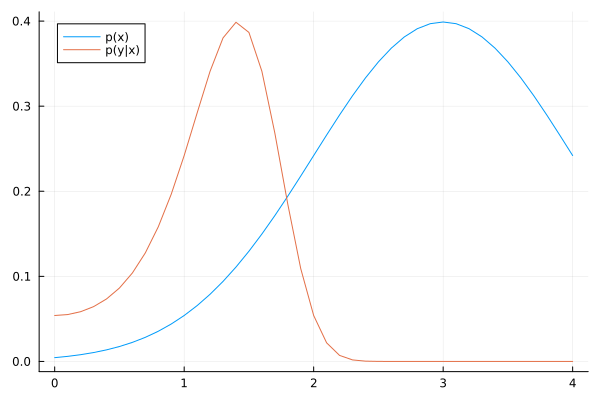

In [73]:
plot(x, [p_x, p_yx], label=["p(x)" "p(y|x)"])

# title!("Frequency of Theta_7 ML Estimate (P=7)")
# xlims!(-1, 2)
# xticks!(-2:0.4:2)
# xlabel!("ML Estimate")
# ylabel!("Frequency (N=100)")
# savefig("./theta7_ml_est_p=7_n=100.png")

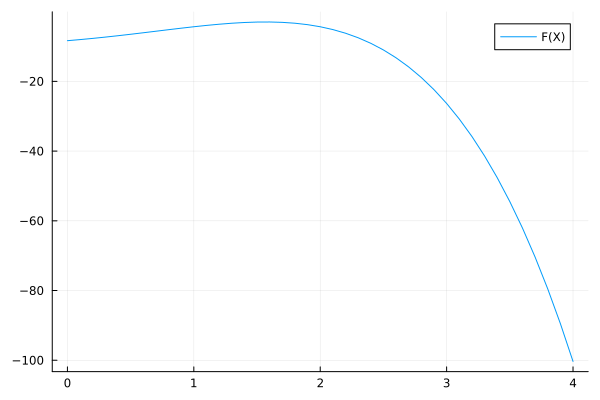

In [76]:
plot(x, [Fx],label="F(X)")

&nbsp;
___

Our $F(x)$ is rather a $F(\phi)$. Because of our particular approximation, $x$ and the parameter $\phi$ *live* on the same scale, but for the rest of the exercise we will talk about $F(\phi)$ to remind us that we are looking for $\phi_0$, the parameter giving us the *best* approximation $q_{\phi_0}(x)$ of the posterior $p(x|y)$.

b) Determine $\phi_0$ (up to a small error) by performing a direct gradient ascent $\phi(\tau + \Delta\tau) = \phi(\tau) + \Delta \tau \cdot \frac{\text{d} F}{\text{d} \phi}$ on $F(\phi)$. Start at $\mu_{pr}$ and plot $\phi(\tau)$ against $\tau$ for some reasonable time interval.  *(3 points)*

*Hint: You can use a step size of $\Delta\tau = 0.01$.*

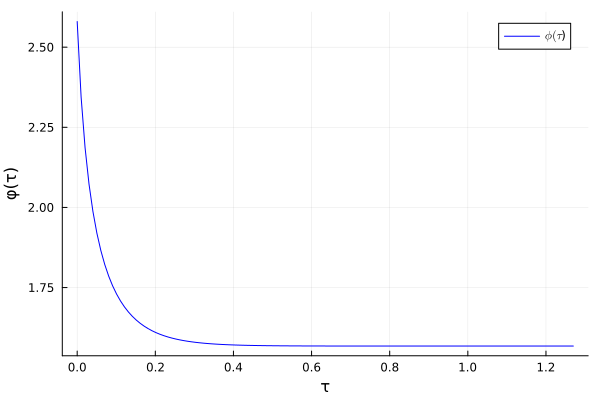

In [88]:
using Plots

function F_prime(x)
	return -(x - mu_pr) / sum_pr - (g(x) - y) * g_prime(x) / sum_gen
end 

phi_prev = mu_pr
phi_next = 0.0

tau = 0.01
err = 1e-8

F_prime(x) = -(x - mu_pr) / sum_pr - (g(x) - y) * g_prime(x) / sum_gen

phis = Float64[]

while true
    phi_next = phi_prev + tau * F_prime(phi_prev)
    push!(phis, phi_next)
    if abs(phi_next - phi_prev) < err
        break
    end
    phi_prev = phi_next
end

x = range(0, length(phis) * tau, length = length(phis))

# Plotting
plot(x, phis, label=L"$\phi(\tau$)", color=:blue)
xlabel!("τ")
ylabel!("φ(τ)")

&nbsp;
___

The (direct) gradient ascent allowed us to find $\phi_0$, but one can argue, that the difference/differential equation, we integrate in (b) might be too complex to be implemented neurally.

To simplify the equation, we introduce the \textit{prediction-error}-quantities $\tilde \epsilon_{gen}$ and $\tilde \epsilon_{pr}$. To compute them, we need two additional differential equations, so that we have now three (coupled) differential equations (but with an easier structure):
\begin{align}
		\dot\phi &= \epsilon_{gen} \cdot g'(\phi) + \epsilon_{pr} \\
        \dot \epsilon_{gen} &= y - g(\phi)  - \Sigma_{gen}\cdot \epsilon_{gen} \\
        \dot \epsilon_{pr} &= \mu_{pr} - \phi - \Sigma_{pr} \cdot \epsilon_{pr}
\end{align}

c) Determine $\phi_0$ (up to a small error) by discretizing and then integrating equations the three differential equations above. Use the same step size as for (b) and plot the evolution of $\phi$, $\epsilon_{pr}$ and $\epsilon_{gen}$ against $\tau$.  *(4 points)*


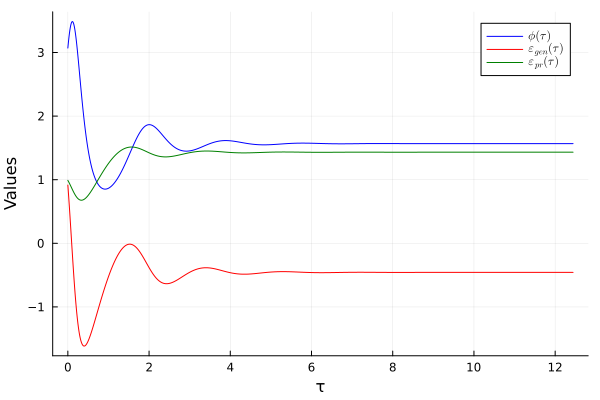

In [93]:
using Plots
eps_pr = 1.0
eps_gen = 1.0

phi_prev = mu_pr
phi_next = 0.0

phis = Float64[]
eps_prs = Float64[]
eps_gens = Float64[]

while true
    phi_next = phi_prev + tau * (eps_gen * g_prime(phi_prev) + eps_pr)
    eps_gen += tau * (y - g(phi_next) - sum_gen * eps_gen)
    eps_pr += tau * (mu_pr - phi_next - sum_pr * eps_pr)
    push!(phis, phi_next)
    push!(eps_prs, eps_pr)
    push!(eps_gens, eps_gen)
    if abs(phi_next - phi_prev) < err
        break
    end
    phi_prev = phi_next
end

x = range(0, length(phis) * tau, length = length(phis))

# Plotting
plot(x, phis, label=L"$\phi(\tau)$", color=:blue)
plot!(x, eps_gens, label=L"$\epsilon_{gen}(\tau)$", color=:red)
plot!(x, eps_prs, label=L"$\epsilon_{pr}(\tau)$", color=:green)
xlabel!("τ")
ylabel!("Values")

&nbsp;
___

d) Which of the two methods used in (b) and (c) converges faster? Why?  *(2 points)*

# insert your solution here ...
When we compare using gradient ascent to using the method of solving the linked differential equations, we find that gradient ascent gets to the answer about ten times faster than the other way. This is because the differential equations are linked together, affecting each other at every step, which makes the results go up and down as shown in figure 4. On the other hand, the method that solves the three differential equations doesn't need us to figure out the complex derivative of F(x), only the simpler derivative of g(x) is needed.

&nbsp;
___
___
&nbsp;

## 2.2 The HGF Julia Implementation and Experimental Design

This exercise is intended to get you started with the HGF Julia implementation and understand the relation between the generative model and the update equations (resulting from variational inversion of the generative model) better.

a) Briefly summarise the content and use of the two Julia packages [HierarchicalGaussianFiltering.jl](https://github.com/ilabcode/HierarchicalGaussianFiltering.jl/tree/main) and [ActionModels.jl](https://github.com/ilabcode/ActionModels.jl). How are the two packages related to each other? *(2 points)*


In [9]:
# insert your solution here ...
### ActionModels.jl
### 	Provides general infrastructure/functionality to run computational models of behvior and cognition via helper functions 
###		like premade_agent(), fit_model(), and plot_parameter_distribution()
###
### HierarchicalGaussianFiltering.jl 
###		Provides functionality for using HGF models specficially within the ActionModels infrastructure by ensuring that the inputs to
### 	the functions provided in ActionModels.jl conform to specifications in create_hgf and update_hgf
### 

&nbsp;
___

In the lecture, we looked at the three level HGF for binary outcomes with perceptual parameters $\kappa$, $\omega$, and $\vartheta$. However, in the software implementation, the parameters $\kappa$ and $\omega$ exist on all levels. On the first level, $\kappa_1$ can be set to 1 to obtain the original model, and $\omega_1$ is undefined. On the highest level, $\kappa_n$ is undefined, and $\omega_n$ corresponds to our previous $\vartheta$. In symmetry to lower levels however, $\omega_3$ describes the log-variance of the Gaussian. Therefore:
\begin{equation}
  \vartheta = \exp(\omega_3)
\end{equation}
in the binary HGF with 3 levels. In this exercise, we will always provide both values to avoid confusion.

b) The Julia packages allow us to simulate beliefs (mean $\mu$, precision $\pi$) and behavior $y$ in response to sensory inputs $u$, using the perceptual model of the HGF (and an appropriate action model). But first, we take a step back and generate sensory inputs $u$ using the HGF. Write a function that implements the generative model for the three level HGF for binary outcomes and generates binary events $u$ according to it. *Hint: These equations were given in the lecture and are not implemented in the toolbox.*

To start, choose the following parameter setting:
\begin{equation}
  \kappa_2 = 1, \quad \omega_2 = -4, \quad \vartheta = \exp(\omega_3) = \exp(-6)
\end{equation}
You can use the following values for the initial states:
\begin{equation}
    x_2^{(0)}=0, \quad  x_3^{(0)}=1
\end{equation}
Plot the resulting traces of $x_3$, $x_2$, and the generated inputs $u$ for a given number of trials (suggestion: plot the trajectories for a trial number of 320). Repeat this procedure a few times and examine the typical traces you get. Also try out different parameter settings, in particular, higher values for $\vartheta$. What do you observe? *(4 points)*

In [9]:
# insert your solution here ...
using HierarchicalGaussianFiltering
using ActionModels

In [58]:
# premade_agent("help")
agent = premade_agent("hgf_binary_softmax_action")
get_states(agent)
get_parameters(agent)
# nothing #hide

┌ Warning:  ("x2", "autoregression_strength") was not set by the user. Using the default: 0
└ @ ActionModels /Users/jeromehadorn/.julia/packages/ActionModels/cSxmG/src/utils/warn_premade_defaults.jl:13
┌ Warning:  ("x3", "initial_precision") was not set by the user. Using the default: 1
└ @ ActionModels /Users/jeromehadorn/.julia/packages/ActionModels/cSxmG/src/utils/warn_premade_defaults.jl:13
┌ Warning:  ("x2", "autoregression_target") was not set by the user. Using the default: 0
└ @ ActionModels /Users/jeromehadorn/.julia/packages/ActionModels/cSxmG/src/utils/warn_premade_defaults.jl:13
┌ Warning:  ("u", "input_precision") was not set by the user. Using the default: Inf
└ @ ActionModels /Users/jeromehadorn/.julia/packages/ActionModels/cSxmG/src/utils/warn_premade_defaults.jl:13
┌ Warning:  ("x2", "volatility") was not set by the user. Using the default: -2
└ @ ActionModels /Users/jeromehadorn/.julia/packages/ActionModels/cSxmG/src/utils/warn_premade_defaults.jl:13
┌ Warning:  ("x1"

Dict{Any, Any} with 17 entries:
  ("x1", "x2", "value_coupling")      => 1
  ("x2", "autoregression_strength")   => 0
  ("u", "input_precision")            => Inf
  ("x2", "autoregression_target")     => 0
  ("x2", "volatility")                => -2
  ("x3", "initial_precision")         => 1
  ("u", "category_means")             => Real[0, 1]
  ("x3", "initial_mean")              => 0
  ("x3", "autoregression_strength")   => 0
  ("x2", "initial_mean")              => 0
  ("x3", "drift")                     => 0
  ("x2", "x3", "volatility_coupling") => 1
  "softmax_action_precision"          => 1
  ("x3", "autoregression_target")     => 0
  ("x2", "initial_precision")         => 1
  ("x2", "drift")                     => 0
  ("x3", "volatility")                => -2

In [59]:
set_parameters!(agent, ("x1", "x2", "value_coupling"), 1.0) # k_1
set_parameters!(agent, ("x2", "x3", "volatility_coupling"), 1.0) # k_2
set_parameters!(agent, ("x2", "volatility"), -6) # w_2
set_parameters!(agent, ("x3", "volatility"), -6) # w_3
set_parameters!(agent, ("x3", "volatility"), -6) # w_3
set_parameters!(agent, ("x2", "initial_precision"), 0) # x2 init
set_parameters!(agent, ("x3", "initial_precision"), 1) # x3 init

nothing #hide

In [66]:
# create N inputs of length 320 where each value is coming from a bernoulli process with p=0.5
N = 100
inputs = rand(rng, [0, 1], N, 320)

UndefVarError: UndefVarError: `rng` not defined

In [63]:
inputs = [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
actions = give_inputs!(agent, inputs)
nothing #hide

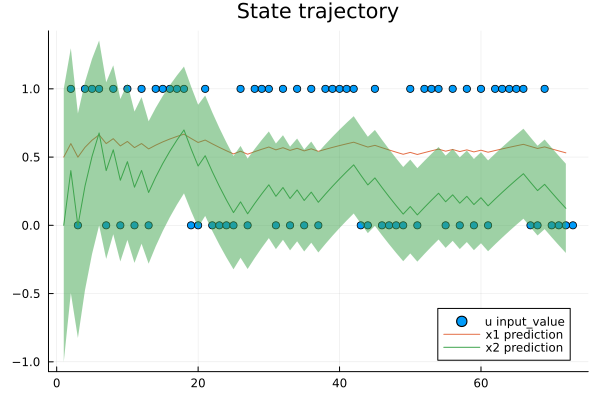

In [65]:
using StatsPlots
using Plots
plot_trajectory(agent, ("u", "input_value"))
plot_trajectory!(agent, ("x1", "prediction"))
plot_trajectory!(agent, ("x2", "prediction"))

&nbsp;
___

c) Decide on one input sequence that you generated, simulate beliefs and responses using the 3-level HGF for binary inputs (perceptual model) in combination with the unit-square sigmoid action model with the same (or other) parameters that you used during input generation. Does your simulated agent correctly track the evolution of $x_3$ and $x_2$? *(3 points)*

*Hint: You can use the premade agent `hgf_unit_square_sigmoid_action`.*

The following table summarises the naming conventions for parameters and states used in the HGF julia package: 
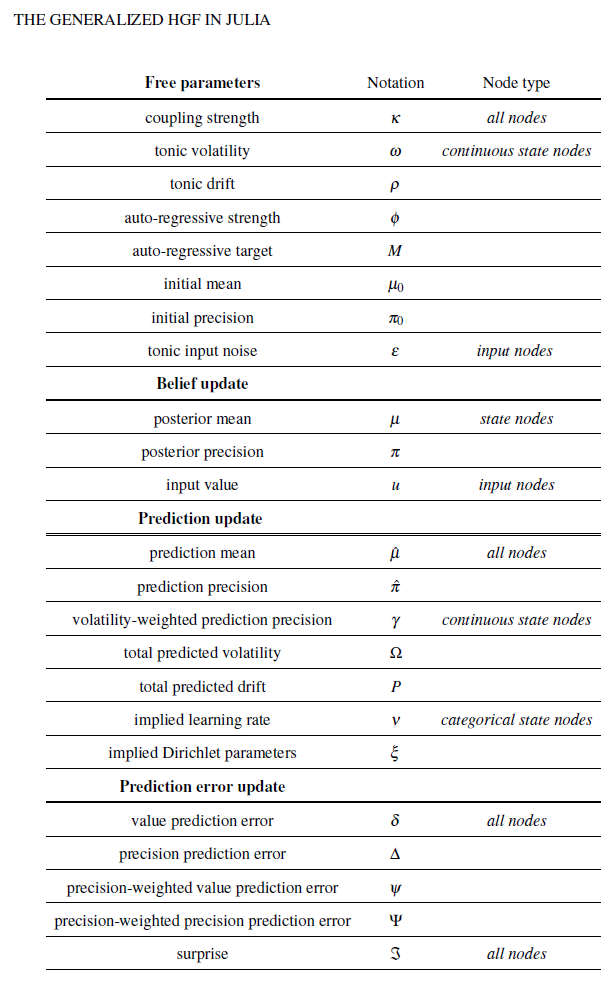


In [11]:
# insert your solution here ...

&nbsp;
___

d) Why, do you think, would it be a good or bad idea to use the generative model of the HGF to generate stimulus sequences to use in an experiment? If you think it's a bad idea, why could it still be a useful model for the agent to invert during perception? *(2 points)*

In [12]:
# insert your solution here ...

&nbsp;
___
___
&nbsp;

## 2.3 Coordinate Choice and Parameter Identifiability in the HGF

In this exercise, you will learn how you can build your own HGF and action models using the respective julia packages. Moreover, we take a closer look at the meaning of the perceptual parameters of the three level HGF for binary outcomes and their relationships. The observations we will make, however, generalize to any HGF with $n$ levels and both categorical as well as continuous outcomes. 

For this exercise, make use of the example binary input sequence that is contained in the `classic_binary_inputs.csv` file within the directory `/docs/src/tutorials/data/`.

In [91]:
hgf_path = dirname(dirname(pathof(HierarchicalGaussianFiltering)))
data_path = hgf_path * "/docs/src/tutorials/data/"
u3 = CSV.read(data_path * "classic_binary_inputs.csv", DataFrame)[!, 1];

a) Simulate beliefs and responses using the 3-level HGF for binary inputs (perceptual model). with the following parameters:

\begin{equation}
  \begin{split}
  \mu_3^{(0)} = 1&, \quad \sigma_3^{(0)} = 1, \\
  \kappa_2 = 2.5&, \quad \omega_2 = -4, \\
  \vartheta = \exp(\omega_3) &= \exp(-6) = 0.0025,
  \end{split}
\end{equation}

in combination with the unit-square sigmoid action model with parameter: 

$$ \zeta = 5. $$

For this exercise, do **NOT** use the premade agent `hgf_unit_square_sigmoid_action` but rather build the 3-level HGF for binary inputs on your own using the resective functionalities of the [software package](https://ilabcode.github.io/HierarchicalGaussianFiltering.jl/dev/) and combine it with a unit-square sigoid action model. *(3 points)*


In [13]:
# insert your solution here ...

&nbsp;
___

b) Try to recover the parameters you used to simulate beliefs and responses using the function `fit_model`, estimating $\zeta$, $\mu_3^{(0)}$, $\kappa_2$, and $\vartheta = \exp(\omega_3)$. You can use the following marginal priors on the free parameters:
\begin{align}
    p(\mu_3^{(0)}) &= \mathcal N(1,0.5) \\
    p(\kappa_2) &= \mathcal N(2.5,0.5) \\
    p(\omega_3) &= \mathcal N(-6,0.5) \\
    p(\zeta) &= \mathcal N(5,1) \\
\end{align}

Inspect the fit of the model and compare the posterior to the chosen prior. Compare the posterior predictive distribution to the simulated beliefs. What do you observe? *(2 points)*


In [14]:
# insert your solution here ...

&nbsp;
___

c) Again, simulate beliefs and responses using your implementation of the 3-level HGF for binary inputs alongside the unit-square sigmoid action model, now with percetpual parameters:
\begin{equation}
  \begin{split}
  \mu_3^{(0)} = 2.5&, \quad \sigma_3^{(0)} = 6.25, \\
  \kappa_2 = 1&, \quad \omega_2 = -4, \\
  \vartheta = \exp(\omega_3) &= \exp(-4.1674) = 0.0155,
  \end{split}
\end{equation}
and action model parameter:
\begin{equation}
  \zeta = 5.
\end{equation}
Compare the belief trajectories with the ones you simulated in (a). What do you find? Can you explain this effect? *(2 points)*

In [15]:
# insert your solution here ...

&nbsp;
___

d) By setting $\kappa_2$ to 1 and/or $\omega_2$ to 0, we can make these parameters seemingly disappear from the model. Try to write down a rule for how you would have to change the other parameters such that only $\mu_3$ is affected by this change, but the belief trajectories on the lower levels stay the same. What does that tell you? *(2 points)*

In [16]:
# insert your solution here ...

&nbsp;
___

e) We can actually get rid of the indeterminacy observed in (b) and (c) by including a readout of $\mu_3$ in our action model. This way, we can estimate all three, $\mu_3^{(0)}$, $\kappa_2$, and $\omega_2$, given observed responses. Try this by creating a new variant of the unit-square sigmoid action model, where $\mu_3$ determines the trial-by-trial decision temperature:

$$ p(y=1|\hat{\mu}_1, \mu_3) = \frac{\hat{\mu}_1^{\exp(-\mu_3)}}{\hat{\mu}_1^{\exp(-\mu_3)} + (1-\hat{\mu}_1)^{\exp(-\mu_3)}} $$

This means that agents will behave less deterministically the more volatile they believe the environment to be.

Repeat the exercise of (a) with the new action model. *(3 points)*

In [17]:
# insert your solution here ...